# CRM Sales Opportunities

An example of ETA analysis using PostGreSQL with common table expressions, window functions and subqueries.
Follow-up visualizations were done in Python (matplotlib).

Dataset used: _CRM Sales Opportunities_ obtained from [MavenAnalytics](https://www.mavenanalytics.io) - B2B sales pipeline data from a fictitious company that sells computer hardware, including information on accounts, products, sales teams, and sales opportunities.

## EXPLORATORY QUERIES
A few examples of what we can look out for when analyzing the dataset.

### Range of sale dates
Check if any of the sales agents had joined/left the organization throughtout the year. We use a subquery to find the first and last date for each agent, from which we get the minimum and maximum value of first and last dates.

In [3]:
-- check the range of dates:
SELECT 
	MIN(first_date) AS min_start_date,
	MAX(first_date) AS max_start_date,
	MIN(last_date) AS min_end_date,
	MAX(last_date) AS max_end_date
FROM 
	(SELECT 
		sales_agent, 
		MIN(close_date) AS first_date, 
		MAX(close_date) AS last_date
	FROM sales_pipeline.csv
	GROUP BY sales_agent) AS subquery;

,min_start_date,max_start_date,min_end_date,max_end_date
0,2017-03-01 00:00:00+00:00,2017-03-10 00:00:00+00:00,2017-12-25 00:00:00+00:00,2017-12-31 00:00:00+00:00


For every sales agent appearing in the _sales_pipeline_ table, the time frame begins between 2017-03-01 and 2017-03-10, and ends between 2017-12-25 and 2017-12-31. 
Therefore all the agents (and consequently, sales teams and regional offices) were active roughly throughout the analyzed time frame.

### Field matches: product
The _product_ field will be used as key value for joins. We can use a query to see if values match between _products_ and _sales_pipelines_ tables.

In [109]:
SELECT 
	DISTINCT p.product AS Products_table_names, 
	sp.product AS SalesPipeline_table_names 
FROM products.csv AS p
FULL JOIN sales_pipeline.csv AS sp
ON p.product = sp.product
WHERE Products_table_names IS null OR SalesPipeline_table_names IS null;

,Products_table_names,SalesPipeline_table_names
0,GTX Pro,None
1,None,GTXPro


There is a consistent difference in spelling of GTX Pro between the 2 tables. The issue will be bypassed by removing all whitespaces from the product name in both tables when joining on the product field.

### Field matches: sales_agent
Similarly, _sales_agent_ field will be used as key value between _sales_teams_ and _sales_pipeline_.

In [108]:
SELECT 
	DISTINCT st.sales_agent AS SalesTeams_table_names, 
	sp.sales_agent AS SalesPipeline_table_names 
FROM sales_teams.csv AS st
FULL JOIN sales_pipeline.csv AS sp
ON st.sales_agent = sp.sales_agent
WHERE SalesTeams_table_names IS null OR SalesPipeline_table_names IS null;

,SalesTeams_table_names,SalesPipeline_table_names
0,Carl Lin,None
1,Elizabeth Anderson,None
2,Natalya Ivanova,None
3,Mei-Mei Johns,None
4,Carol Thompson,None


Within the given timeframe, 5 agents have not appeared in the sales_pipeline table. If it was the opposite, it would be a cause of concern, as sales_pipeline will be our facts table.

## PERFORMANCE OF EACH SALES TEAM
In order to analyze the performance of each sales teams, we query for the total number of closed opportunities, win rate (as ratio of won cases to the total number of cases), total value of closed opportunities, and average value of opportunity. These metrics will be provided for each manager in each regional office.

The query results are visualized by using matplotlib.

In [44]:
-- Performance of each sales team:
SELECT 
	st.manager,
	st.regional_office,
	COUNT(DISTINCT sp.sales_agent) AS agents_in_team,
	COUNT(sp.close_date) AS closed_opportunities,
	ROUND(SUM(CASE WHEN sp.deal_stage = 'Won' THEN 1 END) / COUNT(sp.close_date),2) AS win_rate,
	SUM(sp.close_value) AS total_close_value,
	ROUND(AVG(sp.close_value),2) AS average_value
FROM sales_pipeline.csv AS sp
LEFT JOIN sales_teams.csv AS st
ON sp.sales_agent = st.sales_agent
GROUP BY st.manager, st.regional_office
ORDER BY total_close_value DESC;

,manager,regional_office,agents_in_team,closed_opportunities,win_rate,total_close_value,average_value
0,Melvin Marxen,Central,5,1418,0.62,2251930.0,1588.10
1,Summer Sewald,West,5,1287,0.64,1964750.0,1526.61
2,Rocco Neubert,East,5,1113,0.62,1960545.0,1761.50
3,Celia Rouche,West,5,962,0.63,1603897.0,1667.25
4,Cara Losch,East,5,745,0.64,1130049.0,1516.84
5,Dustin Brinkmann,Central,5,1186,0.63,1094363.0,922.73


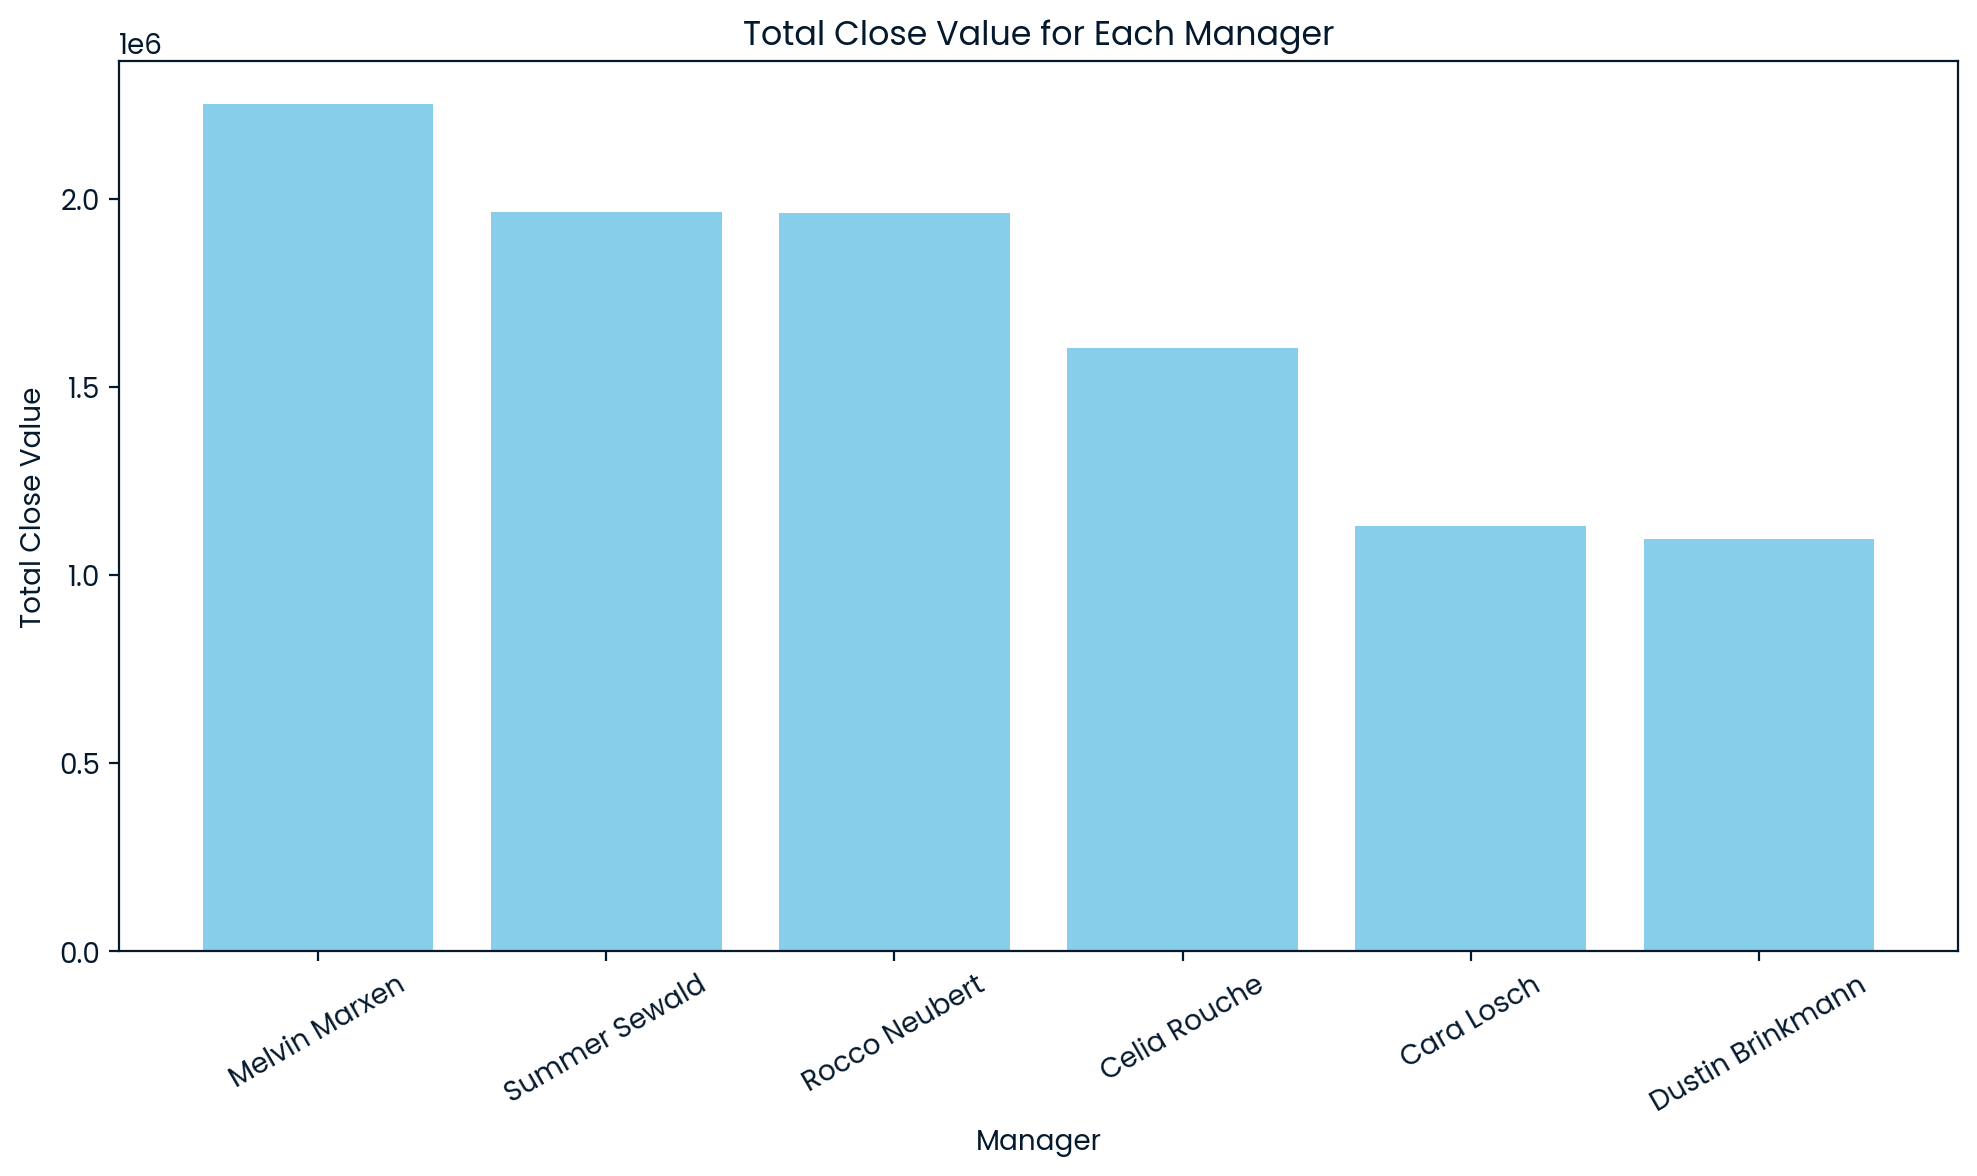

In [38]:
import matplotlib.pyplot as plt

# Create a bar chart of total_close_value for each manager
plt.figure(figsize=(10, 6))
plt.title('Total Close Value for Each Manager')
plt.bar(saleteams['manager'], salesteams['total_close_value'], color='skyblue')
plt.xlabel('Manager')
plt.ylabel('Total Close Value')
plt.xticks(rotation=30, ha='center')
plt.tight_layout()
plt.show()

Despite all the teams having an equal number of agents (5), there is a strong discrepancy between the amount of opportunities among teams. Melvin Marxen boasts the highest number of opportunities at 1418, almost twice of Cara Losch's and Dustin Brinkmann's.

The win rate is consistent among the teams (62% - 64%).

The mean opportunity value for all teams is in the 1500-1700 range, with the single outlier being Dustin Brinkmann's team at 922.73.

## PERFORMANCE OF INDIVIDUAL SALES AGENTS
In order to analyze the performance of each sales agent, the previous query can be expanded by adding the sales_agent field. Additionally, the agents within each regional office were ranked using the DENSE_RANK() window function.

In [72]:
SELECT 
	DENSE_RANK() OVER(PARTITION BY st.regional_office ORDER BY SUM(sp.close_value) DESC) as ranking,
	st.sales_agent,
	st.regional_office,
	st.manager,
	COUNT(sp.close_date) AS closed_opportunities,
	ROUND(SUM(CASE WHEN sp.deal_stage = 'Won' THEN 1 END) / COUNT(sp.close_date),2) AS win_rate,
	SUM(sp.close_value) AS total_close_value,
	ROUND(AVG(sp.close_value),2) AS average_value
FROM sales_pipeline.csv AS sp
LEFT JOIN sales_teams.csv AS st
ON sp.sales_agent = st.sales_agent
GROUP BY st.manager, st.regional_office, st.sales_agent
ORDER BY st.regional_office, total_close_value DESC;

,ranking,sales_agent,regional_office,manager,closed_opportunities,win_rate,total_close_value,average_value
0,1,Darcel Schlecht,Central,Melvin Marxen,553,0.63,1153214.0,2085.38
1,2,Gladys Colclough,Central,Melvin Marxen,232,0.58,345674.0,1489.97
2,3,Marty Freudenburg,Central,Melvin Marxen,194,0.63,291195.0,1501.01
3,4,Jonathan Berthelot,Central,Melvin Marxen,264,0.65,284886.0,1079.11
4,5,Anna Snelling,Central,Dustin Brinkmann,336,0.62,275056.0,818.62
5,6,Cecily Lampkin,Central,Dustin Brinkmann,160,0.67,229800.0,1436.25
6,7,Moses Frase,Central,Dustin Brinkmann,195,0.66,207182.0,1062.47
7,8,Lajuana Vencill,Central,Dustin Brinkmann,231,0.55,194632.0,842.56
8,9,Versie Hillebrand,Central,Dustin Brinkmann,264,0.67,187693.0,710.96
9,10,Niesha Huffines,Central,Melvin Marxen,175,0.60,176961.0,1011.21


Defaulting to user installation because normal site-packages is not writeable


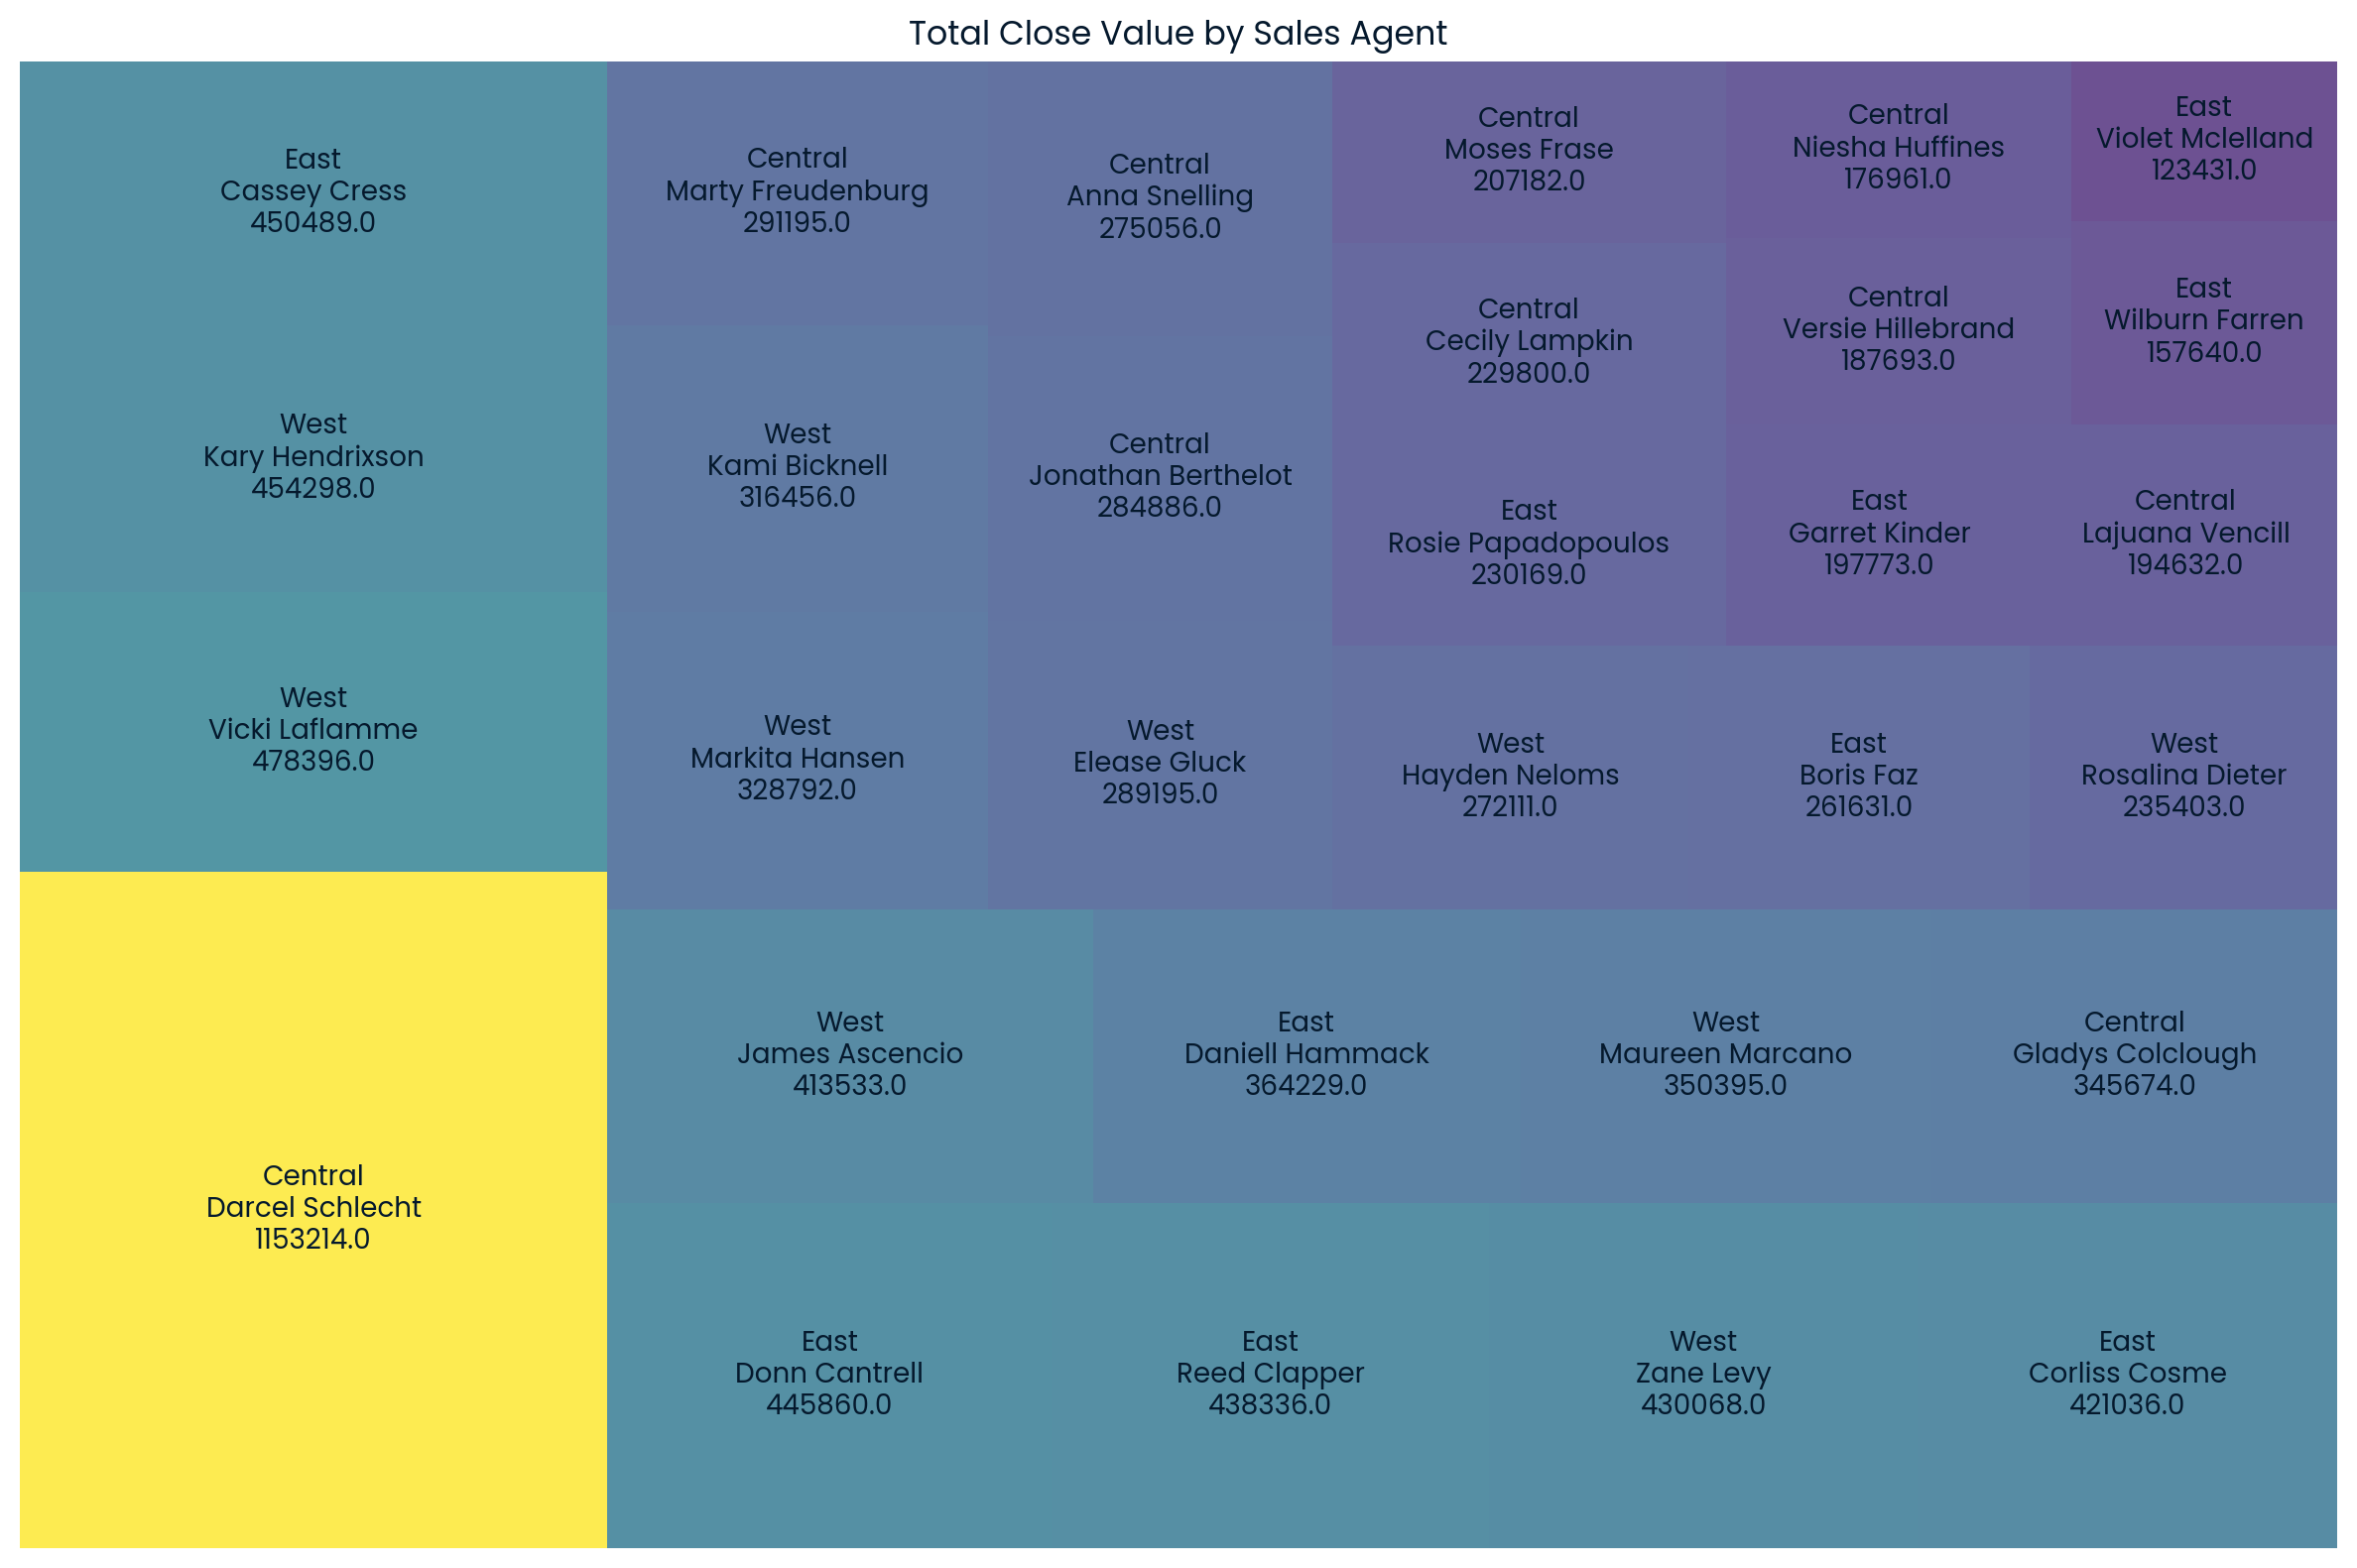

In [53]:
!pip install squarify
import matplotlib.pyplot as plt
import squarify

labels = agents['regional_office'] + "\n" + agents['sales_agent'] + "\n" + agents['total_close_value'].astype(str)
sizes = agents['total_close_value']
colors = plt.cm.viridis(sizes / max(sizes))

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8)
plt.title('Total Close Value by Sales Agent')
plt.axis('off')
plt.tight_layout()
plt.show()

The by far highest total close value belongs to sales agent Darcel Schlecht, who belongs in Melvin Marxen's team, at 1 153 214, over two times above the second place (Vicki Laflamme's 478 396). Unsurprisingly, Darcel Schlecht also amassed the highest number of closed sales at 553. This is a likely explanation to the success of Melvin Marxen's sales team. 

This warrants further investigation. We can use a query with a common table expression to compare Darcel Schlecht's results with the average for all agents:

In [71]:
WITH cte AS (
    SELECT 
        st.sales_agent,
        COUNT(sp.close_date) AS closed_opportunities,
        ROUND(SUM(CASE WHEN sp.deal_stage = 'Won' THEN 1 ELSE 0 END) / COUNT(sp.close_date), 2) AS win_rate,
        SUM(sp.close_value) AS total_close_value,
        ROUND(AVG(sp.close_value), 2) AS average_value
    FROM sales_pipeline.csv AS sp
    LEFT JOIN sales_teams.csv AS st
    ON sp.sales_agent = st.sales_agent
    GROUP BY st.manager, st.regional_office, st.sales_agent
)

SELECT 
    'Mean for all agents' AS value,
    ROUND(AVG(win_rate),2) AS win_rate, 
    ROUND(AVG(closed_opportunities),0) AS closed_opportunities, 
    ROUND(AVG(total_close_value),0) AS close_value, 
    ROUND(AVG(average_value),2) AS average_value
FROM cte
UNION ALL
SELECT
	'Darcel Schlecht' as value,
	win_rate,
	closed_opportunities,
	total_close_value,
	average_value
FROM cte
WHERE sales_agent = 'Darcel Schlecht';

,value,win_rate,closed_opportunities,close_value,average_value
0,Mean for all agents,0.63,224.0,333518.0,1524.94
1,Darcel Schlecht,0.63,553.0,1153214.0,2085.38


While the win rate is perfectly average, the other three metrics are far above the average. We shall revisit this later on.

## PERFORMANCE PER PRODUCT
To evaluate each product's preformance, we query for the total sales value in each quarter of the year, for each product type.

In [40]:
-- Sales per product for each quarter:
SELECT 
	p.product, 
	p.series, 
	p.sales_price,
	EXTRACT(QUARTER from sp.close_date) as quarter,
	SUM(sp.close_value) as total_sales_value
FROM products.csv AS p
LEFT JOIN sales_pipeline.csv AS sp
ON REPLACE(p.product,' ','') = REPLACE(sp.product,' ','') -- as found previously, "GTX Pro" is spelled as "GTXPro" in sp.
WHERE sp.deal_stage = 'Won'
GROUP BY p.product, p.series, p.sales_price, quarter
ORDER BY quarter, total_sales_value DESC;

,product,series,sales_price,quarter,total_sales_value
0,GTX Pro,GTX,4821,1,376966.0
1,MG Advanced,MG,3393,1,290207.0
2,GTX Plus Pro,GTX,5482,1,278081.0
3,GTX Plus Basic,GTX,1096,1,88512.0
4,GTX Basic,GTX,550,1,69204.0
5,GTK 500,GTK,26768,1,25897.0
6,MG Special,MG,55,1,5805.0
7,GTX Pro,GTX,4821,2,1078522.0
8,GTX Plus Pro,GTX,5482,2,780434.0
9,MG Advanced,MG,3393,2,681955.0


Every quarter, **GTX Pro** was the top contributor to the total sales value, with **MG Advanced** and **GTX Plus Pro** variously in the 2nd and 3rd spot. Likewise, **MG Special** was consistently at the last place.

## ACCOUNTS

## SALES OVER TIME
In order to analyze the month-over-month trends in sales, we query for the total number of won/lost opportunities, total value of closed sales, and the difference between the current and previous month. The metrics are provided for each month.

The query results are visualized by using matplotlib.

In [35]:
-- Identify any month-over-month trends:
SELECT 
	EXTRACT(YEAR from close_date) AS year,
	EXTRACT(MONTH from close_date) AS month,
	SUM(CASE WHEN deal_stage = 'Won' THEN 1 END) AS won,
	SUM(CASE WHEN deal_stage = 'Lost' THEN 1 END) AS lost,
	COUNT(opportunity_id) AS total_closed_opportunities,
	SUM(close_value) AS closed_sales_value,
	SUM(close_value) - LAG(closed_sales_value) OVER (ORDER BY month) AS vs_previous_month
FROM sales_pipeline.csv
WHERE close_date IS NOT null
GROUP BY year, month
ORDER BY month;

,year,month,won,lost,total_closed_opportunities,closed_sales_value,vs_previous_month
0,2017,3,531.0,116.0,647,1134672.0,NaN
1,2017,4,285.0,301.0,586,721932.0,-412740.0
2,2017,5,438.0,367.0,805,1025713.0,303781.0
3,2017,6,531.0,110.0,641,1338466.0,312753.0
4,2017,7,308.0,319.0,627,696932.0,-641534.0
5,2017,8,446.0,339.0,785,1050059.0,353127.0
6,2017,9,503.0,132.0,635,1235264.0,185205.0
7,2017,10,279.0,287.0,566,731980.0,-503284.0
8,2017,11,406.0,362.0,768,938943.0,206963.0
9,2017,12,511.0,140.0,651,1131573.0,192630.0


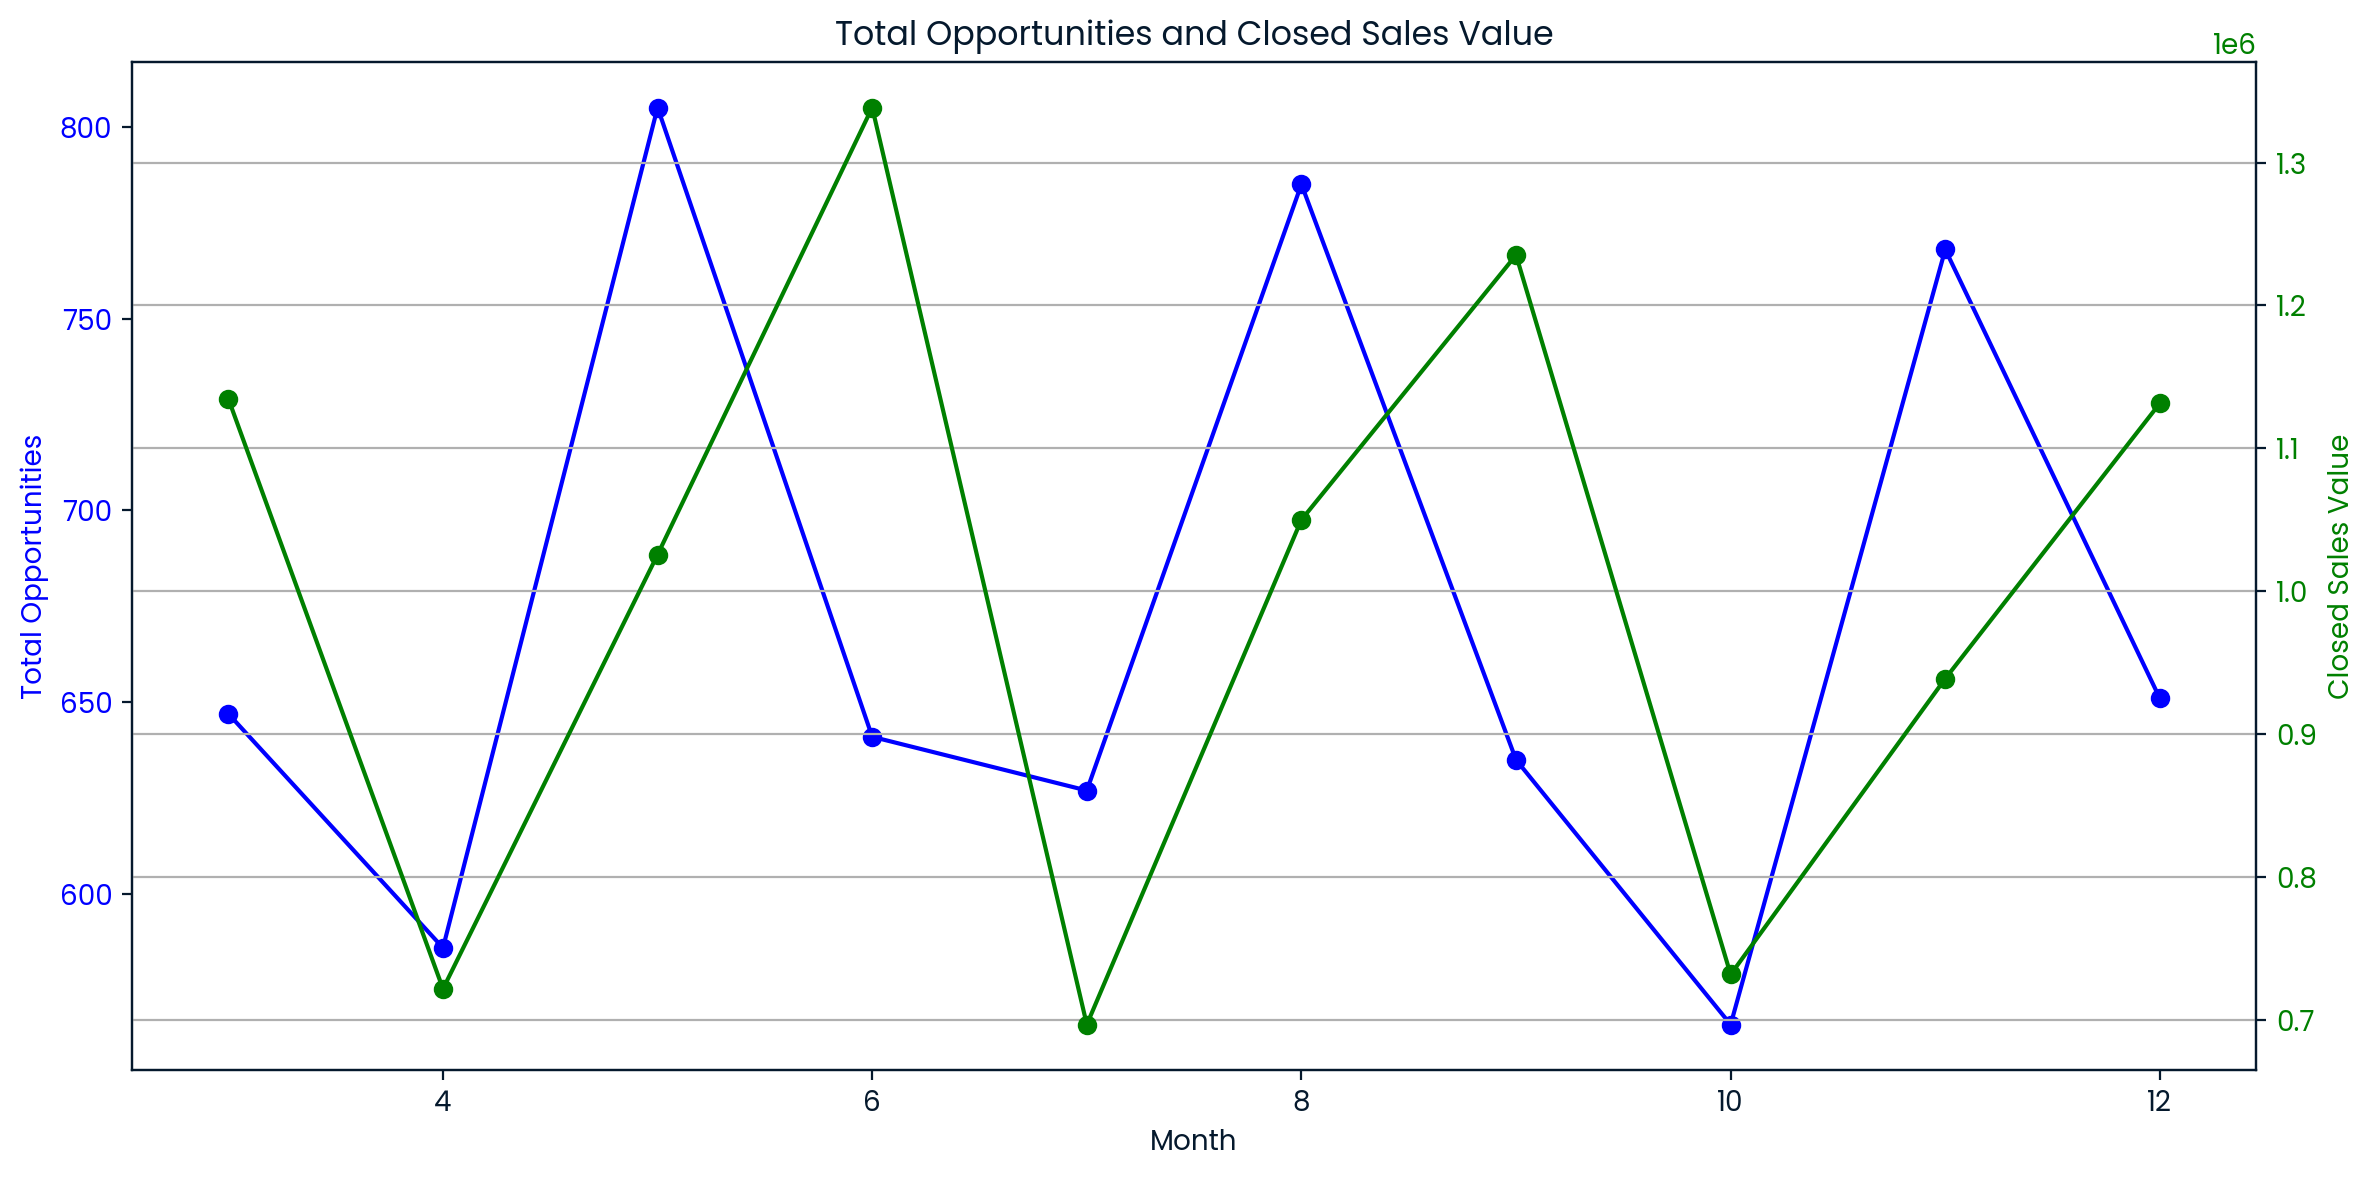

In [39]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))
plt.title('Total Opportunities and Closed Sales Value')

ax1.plot(SalesOverTime['month'], SalesOverTime['total_closed_opportunities'], label='Total Opportunities', marker='o', color='b')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Opportunities', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(SalesOverTime['month'], SalesOverTime['closed_sales_value'], label='Closed Sales Value', marker='o', color='g')
ax2.set_ylabel('Closed Sales Value', color='g')
ax2.tick_params(axis='y', labelcolor='g')

fig.tight_layout()
plt.grid(True)
plt.show()

The total value of closed sales is periodical, with visible peaks in March, June, August and December.

The visible shift between total opportunities and closed sales value can be explained by the delay between opening a new opportunity and closing it.